# Evaluate trained model

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import random
import math
import re
import time
import tensorflow as tf
import matplotlib
import matplotlib.patches as patches
import json
import skimage.io
from IPython.display import clear_output
import numpy as np

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log
import xavi
import coco

ROOT_DIR = os.getcwd() # Root directory of the project
XAVI_DIR = os.path.join(ROOT_DIR, "XAVI_Dataset") # Xavi Dataset directory
MODEL_DIR = os.path.join(XAVI_DIR, "model") # Directory to save trained model
DEFAULT_LOGS_DIR = os.path.join(MODEL_DIR, "logs") # Directory to save logs
XAVI_MODEL = os.path.join(DEFAULT_LOGS_DIR, "xavi51220210430T1046", "mask_rcnn_xavi512_0040.h5") # Local path to trained weights file
COCO_MODEL = "mask_rcnn_coco.h5"
TRAINING_SUBSET = "train512"
TEST_SUBSET = "test512"
COCO_DIR = os.path.join(os.getcwd(), "COCO_Dataset") # Xavi Dataset directory
COCO_TEST_SUBSET = "minival"

In [6]:
# Folder of resulting images
RES_IMAGES = "resulting images"
XAVI_MOD = 'XAVI Model'
COCO_MOD = 'COCO Model'
XAVI_DAT = 'XAVI Dataset'
COCO_DAT = 'COCO Dataset'

if not os.path.exists('resulting images'):
    os.makedirs('resulting images')
if not os.path.exists(os.path.join(RES_IMAGES, XAVI_MOD)):
    os.makedirs(os.path.join(RES_IMAGES, XAVI_MOD))
if not os.path.exists(os.path.join(RES_IMAGES, COCO_MOD)):
    os.makedirs(os.path.join(RES_IMAGES, COCO_MOD))
if not os.path.exists(os.path.join(RES_IMAGES, XAVI_MOD, XAVI_DAT)):
    os.makedirs(os.path.join(RES_IMAGES, XAVI_MOD, XAVI_DAT))
if not os.path.exists(os.path.join(RES_IMAGES, XAVI_MOD, COCO_DAT)):
    os.makedirs(os.path.join(RES_IMAGES, XAVI_MOD, COCO_DAT))
if not os.path.exists(os.path.join(RES_IMAGES, COCO_MOD, XAVI_DAT)):
    os.makedirs(os.path.join(RES_IMAGES, COCO_MOD, XAVI_DAT))
if not os.path.exists(os.path.join(RES_IMAGES, COCO_MOD, COCO_DAT)):
    os.makedirs(os.path.join(RES_IMAGES, COCO_MOD, COCO_DAT))

## Load datasets and models

### XAVI dataset

In [7]:
# Build validation dataset
json_categories = json.load(open(os.path.join(XAVI_DIR, TEST_SUBSET, "categories.json")))["Categories"]
xavi_dataset = xavi.XaviDataset()
xavi_dataset.load_xavi(XAVI_DIR, TEST_SUBSET, xavi.MasksType["PNG"], json_categories, (512, 512))
xavi_dataset.prepare()

print("Images: {}\nClasses: {}".format(len(xavi_dataset.image_ids), xavi_dataset.class_names))

Images: 9848
Classes: ['BG', 'Human', 'Vehicle_Car']


### COCO dataset

In [8]:
# Build validation dataset
coco_dataset = coco.CocoDataset()
coco_dataset.load_coco(COCO_DIR, COCO_TEST_SUBSET, class_ids=[1,3])
coco_dataset.prepare()

clear_output(wait=True)
print("Images: {}\nClasses: {}".format(len(coco_dataset.image_ids), coco_dataset.class_names))

Images: 2869
Classes: ['BG', 'person', 'car']


### XAVI model

In [9]:
config = xavi.XaviConfig(json_categories)

# Create model in inference mode
xavi_model = modellib.MaskRCNN(mode="inference", model_dir=DEFAULT_LOGS_DIR, config=config)

# Load weights
print("Loading weights ", XAVI_MODEL)
xavi_model.load_weights(XAVI_MODEL, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use `tf.cast` instead.
Loading weights  E:\OneDrive - Universitat de les Illes Balears\2020-2021\TFG\Github\Mask_RCNN-2.1\XAVI_Dataset\model\logs\xavi51220210430T1046\mask_rcnn_xavi512_0040.h5


### COCO model

In [10]:
config = coco.CocoConfig()

# Override the training configurations with a few changes for inferencing
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()

# Create model in inference mode
coco_model = modellib.MaskRCNN(mode="inference", model_dir=DEFAULT_LOGS_DIR,
                              config=config)

# Load weights
print("Loading weights ", COCO_MODEL)
coco_model.load_weights(COCO_MODEL, by_name=True)

Loading weights  mask_rcnn_coco.h5


### Pick random images from each dataset

In [11]:
N_RES_IMAGES = 1000

xavi_ids = np.random.choice(xavi_dataset.image_ids, N_RES_IMAGES, replace=False)
coco_ids = np.random.choice(coco_dataset.image_ids, N_RES_IMAGES, replace=False)

## Functions

In [12]:
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline 

# Return a Matplotlib Axes array to be used in all visualizations in the notebook. 
# Provide a central point to control graph sizes.
# Adjust the size attribute to control how big to render images
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Evaluation of XAVI model with XAVI dataset

### Compute mAP @ IoU=50 on Batch of Images

On all images of sample, storing resulting plots:

In [23]:
save_dir = os.path.join(ROOT_DIR, "resulting images", "XAVI Model", "XAVI Dataset")
(APs, class_APs) = utils.compute_batch_ap(xavi_dataset, config, xavi_model, xavi_ids, save_folder=save_dir, show_images = False, target_classes=(1,2))
APS_XaviModel_XaviDataset = np.mean(APs)
APS_XaviModel_XaviDataset_humans = np.mean(class_APs[1])
APS_XaviModel_XaviDataset_cars = np.mean(class_APs[2])

print("mAP @ IoU=50: ", APS_XaviModel_XaviDataset)
print("Humans mAP @ IoU=50: ", APS_XaviModel_XaviDataset_humans)
print("Cars mAP @ IoU=50: ", APS_XaviModel_XaviDataset_cars)

Number of skipped images for class 1: 173
Number of skipped images for class 2: 655
mAP @ IoU=50:  0.7404161636727218
Humans mAP @ IoU=50:  0.6970599622580268
Cars mAP @ IoU=50:  0.7673050395172575


### Example

#### Visualization:

image ID: xavi.2498 (2497) E:\OneDrive - Universitat de les Illes Balears\2020-2021\TFG\Github\Mask_RCNN-2.1\XAVI_Dataset\test512\RGB\photo512_000000002606_City.jpg


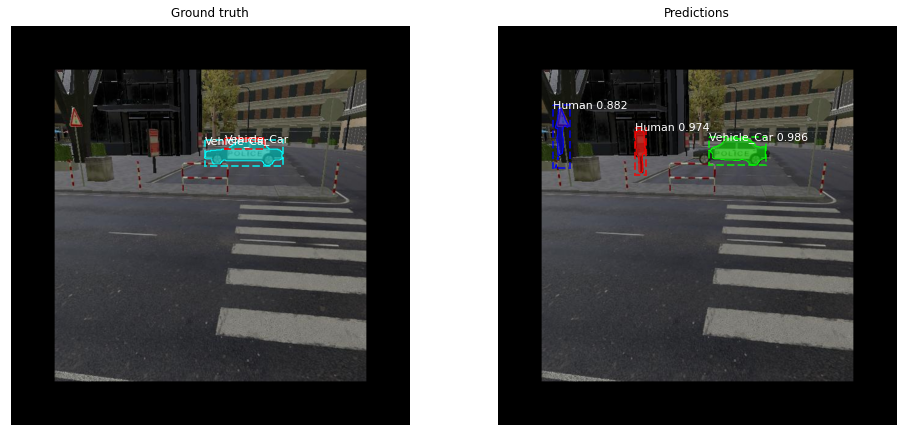

In [24]:
# image_id = 297
image_id = random.choice(xavi_dataset.image_ids)
info = xavi_dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, xavi_dataset.image_reference(image_id)))
ax = get_ax(rows=1, cols=2, size=8)

# Ground truth
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(xavi_dataset, config, image_id, use_mini_mask=False)

# Prediction
results = xavi_model.detect([image]) # class_change = bike -> car
r = results[0]

# Visualization
visualize.display_instances(image, gt_bbox, 
                            gt_mask, 
                            gt_class_id, 
                            xavi_dataset.class_names, 
                            ax=ax[0], 
                            title="Ground truth", 
                            plot_show=False)
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            xavi_dataset.class_names, 
                            r['scores'], 
                            ax=ax[1],
                            title="Predictions", 
                            plot_show=False)

plt.show()

AP, precisions, recalls, overlaps = utils.compute_ap(
                                    gt_bbox, gt_class_id, gt_mask,
                                    r['rois'], r['class_ids'], r['scores'], r['masks'])

#### Precision-Recall:

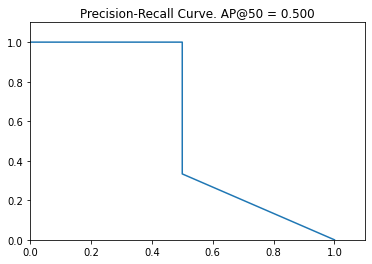

In [25]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

#### Confusion matrix:

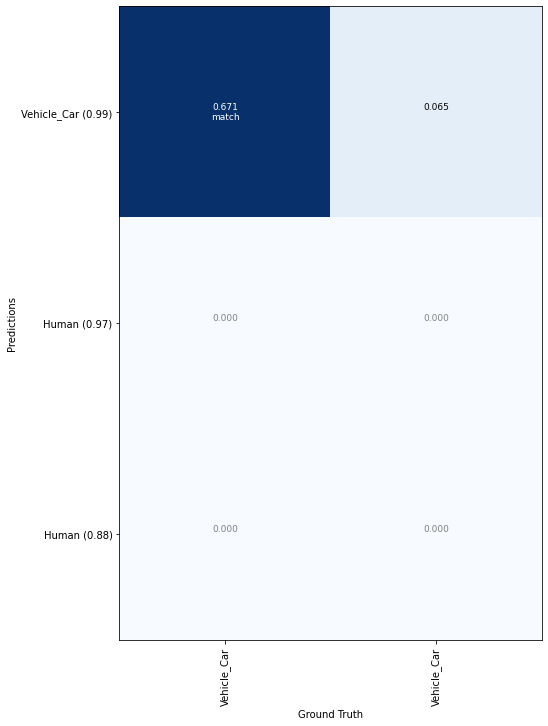

In [26]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, xavi_dataset.class_names)

## Evaluation of XAVI model with COCO Dataset

### Compute mAP @ IoU=50 on Batch of Images

On all images of sample, storing resulting plots:

In [27]:
save_dir = os.path.join(ROOT_DIR, "resulting images", "XAVI Model", "COCO Dataset")
(APs, class_APs) = utils.compute_batch_ap(coco_dataset, config, xavi_model, coco_ids, save_folder=save_dir, show_images = False, target_classes=(1,2))
APS_XaviModel_CocoDataset = np.mean(APs)
APS_XaviModel_CocoDataset_humans = np.mean(class_APs[1])
APS_XaviModel_CocoDataset_cars = np.mean(class_APs[2])

print("mAP @ IoU=50: ", APS_XaviModel_CocoDataset)
print("Humans mAP @ IoU=50: ", APS_XaviModel_CocoDataset_humans)
print("Cars mAP @ IoU=50: ", APS_XaviModel_CocoDataset_cars)

Number of skipped images for class 1: 58
Number of skipped images for class 2: 818
mAP @ IoU=50:  0.2040249562219456
Humans mAP @ IoU=50:  0.22214514749732878
Cars mAP @ IoU=50:  0.10407192079903005


### Example

#### Visualization:

COCO_val2014_000000515828.jpg
image ID: coco.515828 (2765) http://cocodataset.org/#explore?id=515828


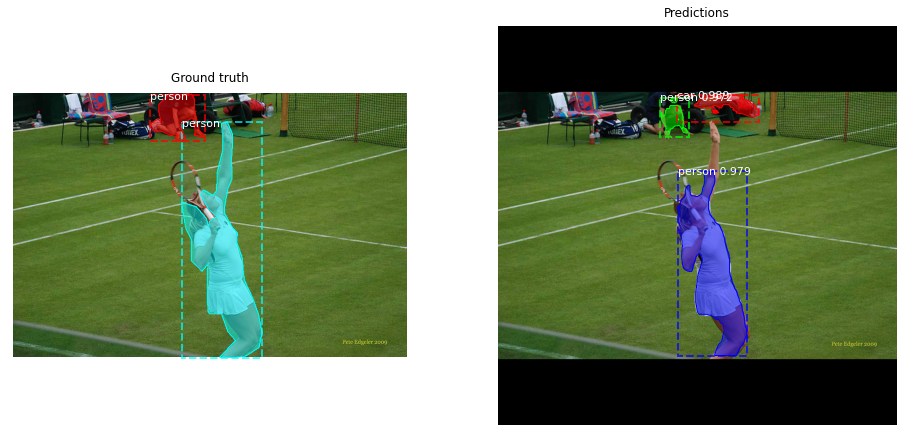

In [28]:
# image_id = 73
image_id = random.choice(coco_dataset.image_ids)
info = coco_dataset.image_info[image_id]
print(os.path.split(info["path"])[1])
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, coco_dataset.image_reference(image_id)))
ax = get_ax(rows=1, cols=2, size=8)

# Ground truth
image = coco_dataset.load_image(image_id)
mask, class_ids = coco_dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)
visualize.display_instances(image, bbox, 
                            mask, 
                            class_ids, 
                            coco_dataset.class_names, 
                            ax=ax[0], 
                            title="Ground truth", 
                            plot_show=False)

# Prediction
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(coco_dataset, config, image_id, use_mini_mask=False)
results = xavi_model.detect([image], min_confidence=0.9, verbose=None)
r = results[0]
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            coco_dataset.class_names, 
                            r['scores'], 
                            ax=ax[1],
                            title="Predictions", 
                            plot_show=False)

plt.show()

#### Precision-Recall:

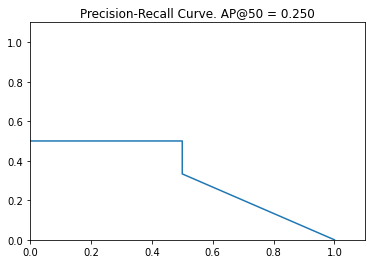

In [29]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

#### Confusion matrix:

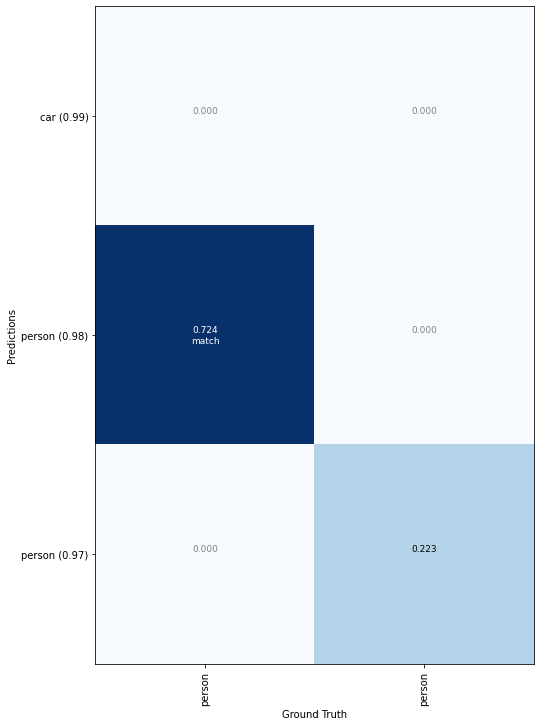

In [30]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, coco_dataset.class_names)

## Evaluation of COCO model with XAVI dataset

### Compute mAP @ IoU=50 on Batch of Images

In [31]:
save_dir = os.path.join(ROOT_DIR, "resulting images", "COCO Model", "XAVI Dataset")
(APs, class_APs) = utils.compute_batch_ap(xavi_dataset, config, coco_model, xavi_ids, class_change=[(3,2)], class_n=2, save_folder=save_dir, show_images = False, target_classes=(1,2))
APS_CocoModel_XaviDataset = np.mean(APs)
APS_CocoModel_XaviDataset_humans = np.mean(class_APs[1])
APS_CocoModel_XaviDataset_cars = np.mean(class_APs[2])

print("mAP @ IoU=50: ", APS_CocoModel_XaviDataset)
print("Humans mAP @ IoU=50: ", APS_CocoModel_XaviDataset_humans)
print("Cars mAP @ IoU=50: ", APS_CocoModel_XaviDataset_cars)

Number of skipped images for class 1: 173
Number of skipped images for class 2: 655
mAP @ IoU=50:  0.6824270268458223
Humans mAP @ IoU=50:  0.7508361349719849
Cars mAP @ IoU=50:  0.4371520602400752


### Example

#### Visualization:

image ID: xavi.689 (688) E:\OneDrive - Universitat de les Illes Balears\2020-2021\TFG\Github\Mask_RCNN-2.1\XAVI_Dataset\test512\RGB\photo512_000000000710_City.jpg


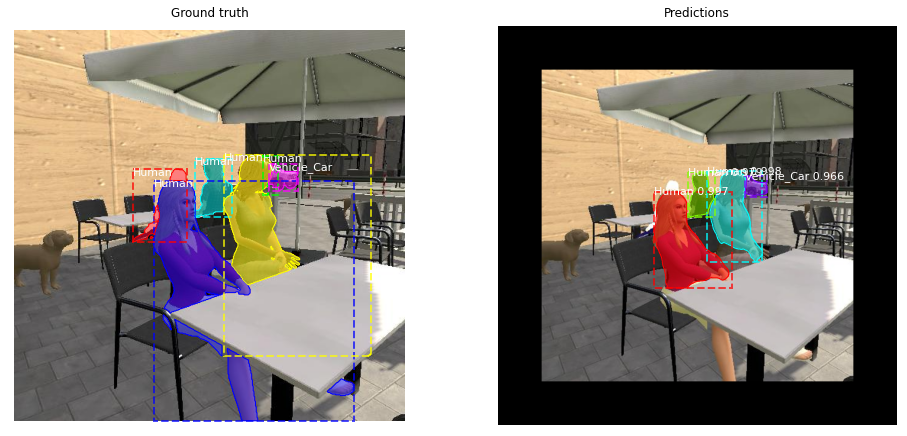

In [32]:
# image_id = 297
image_id = random.choice(xavi_dataset.image_ids)
info = xavi_dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, xavi_dataset.image_reference(image_id)))
ax = get_ax(rows=1, cols=2, size=8)

# Ground truth
image = xavi_dataset.load_image(image_id)
mask, class_ids = xavi_dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)
visualize.display_instances(image, bbox, 
                            mask, 
                            class_ids, 
                            xavi_dataset.class_names, 
                            ax=ax[0], 
                            title="Ground truth", 
                            plot_show=False)

# Prediction
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(xavi_dataset, config, image_id, use_mini_mask=False)
results = coco_model.detect([image], min_confidence=0.9, verbose=None, class_change=[(3,2)], class_n=2) # class_change = bike -> car
r = results[0]
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            xavi_dataset.class_names, 
                            r['scores'], 
                            ax=ax[1],
                            title="Predictions", 
                            plot_show=False)

plt.show()

#### Precision-Recall:

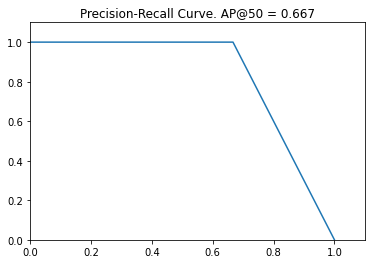

In [33]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

#### Confusion matrix:

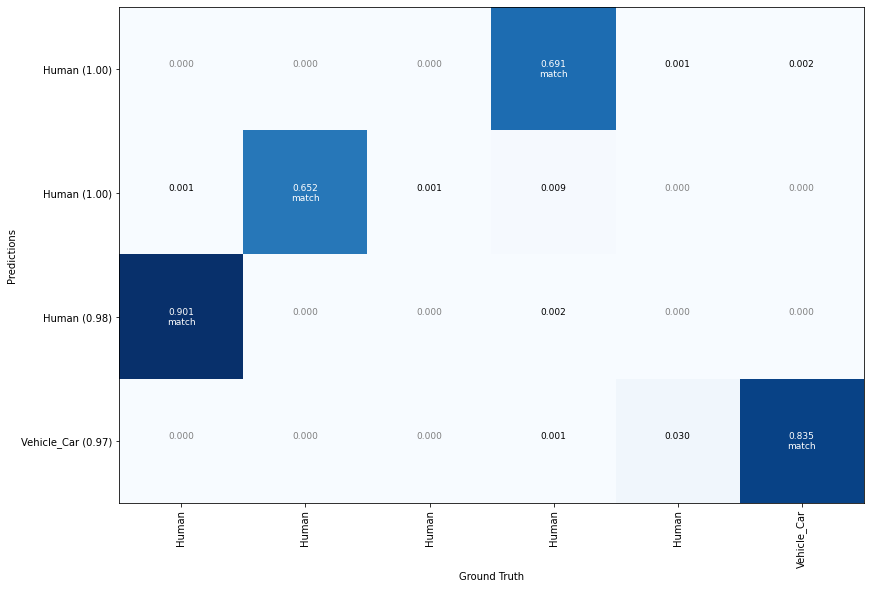

In [34]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, xavi_dataset.class_names)

## Evaluation of COCO model with COCO Dataset

### Compute mAP @ IoU=50 on Batch of Images

On all images of sample, storing resulting plots:

In [35]:
save_dir = os.path.join(ROOT_DIR, "resulting images", "COCO Model", "COCO Dataset")
(APs, class_APs) = utils.compute_batch_ap(coco_dataset, config, coco_model, coco_ids, class_change=[(3,2)], class_n=2, save_folder=save_dir, show_images = False, target_classes=(1,2))
APS_CocoModel_CocoDataset = np.mean(APs)
APS_CocoModel_CocoDataset_humans = np.mean(class_APs[1])
APS_CocoModel_CocoDataset_cars = np.mean(class_APs[2])

print("mAP @ IoU=50: ", APS_CocoModel_CocoDataset)
print("Humans mAP @ IoU=50: ", APS_CocoModel_CocoDataset_humans)
print("Cars mAP @ IoU=50: ", APS_CocoModel_CocoDataset_cars)

Number of skipped images for class 1: 58
Number of skipped images for class 2: 818
mAP @ IoU=50:  0.7694144385129769
Humans mAP @ IoU=50:  0.7940806483154499
Cars mAP @ IoU=50:  0.5646106564564192


### Example

#### Visualization:

COCO_val2014_000000196442.jpg
image ID: coco.196442 (2808) http://cocodataset.org/#explore?id=196442


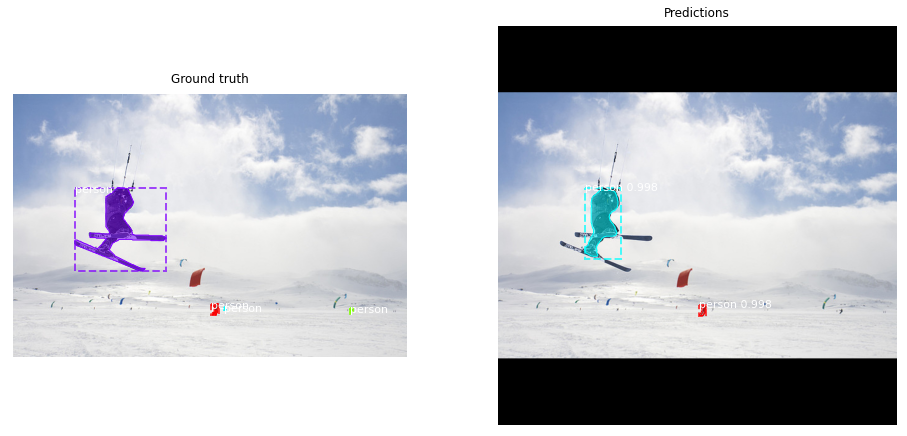

In [36]:
# image_id = 73
image_id = random.choice(coco_dataset.image_ids)
info = coco_dataset.image_info[image_id]
print(os.path.split(info["path"])[1])
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, coco_dataset.image_reference(image_id)))
ax = get_ax(rows=1, cols=2, size=8)

# Ground truth
image = coco_dataset.load_image(image_id)
mask, class_ids = coco_dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)
visualize.display_instances(image, bbox, 
                            mask, 
                            class_ids, 
                            coco_dataset.class_names, 
                            ax=ax[0], 
                            title="Ground truth", 
                            plot_show=False)

# Prediction
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(coco_dataset, config, image_id, use_mini_mask=False)
results = coco_model.detect([image], min_confidence=0.9, class_change=[(3,2)], class_n=2) # class_change = bike -> car
r = results[0]
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], 
                            coco_dataset.class_names, 
                            r['scores'], 
                            ax=ax[1],
                            title="Predictions", 
                            plot_show=False)

plt.show()

#### Precision-Recall:

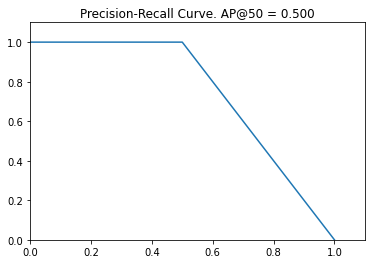

In [37]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

#### Confusion matrix:

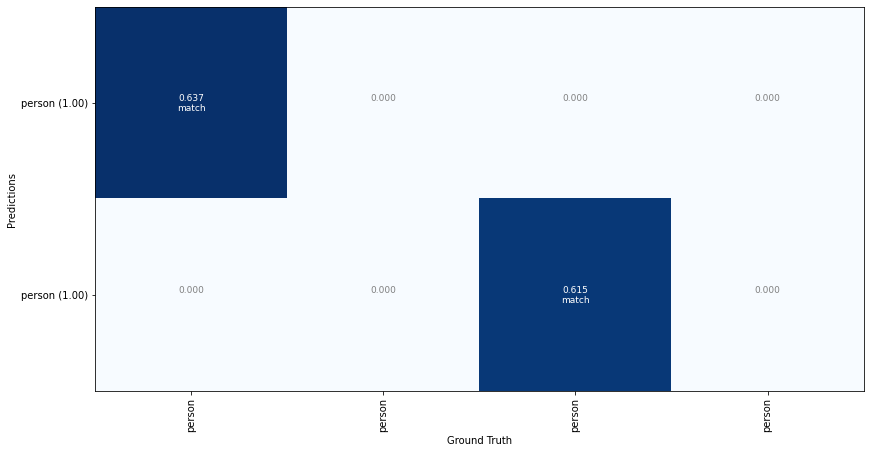

In [38]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, coco_dataset.class_names)

## RESULTS

### All classes

In [39]:
print("Custom model, Custom dataset: {}".format(APS_XaviModel_XaviDataset))
print("Custom model, COCO dataset: {}".format(APS_XaviModel_CocoDataset))
print("COCO model, Custom dataset: {}".format(APS_CocoModel_XaviDataset))
print("COCO model, COCO dataset: {}".format(APS_CocoModel_CocoDataset))

Custom model, Custom dataset: 0.7404161636727218
Custom model, COCO dataset: 0.2040249562219456
COCO model, Custom dataset: 0.6824270268458223
COCO model, COCO dataset: 0.7694144385129769


### Humans

In [40]:
print("Custom model, Custom dataset: {}".format(APS_XaviModel_XaviDataset_humans))
print("Custom model, COCO dataset: {}".format(APS_XaviModel_CocoDataset_humans))
print("COCO model, Custom dataset: {}".format(APS_CocoModel_XaviDataset_humans))
print("COCO model, COCO dataset: {}".format(APS_CocoModel_CocoDataset_humans))

Custom model, Custom dataset: 0.6970599622580268
Custom model, COCO dataset: 0.22214514749732878
COCO model, Custom dataset: 0.7508361349719849
COCO model, COCO dataset: 0.7940806483154499


### Cars

In [41]:
print("Custom model, Custom dataset: {}".format(APS_XaviModel_XaviDataset_cars))
print("Custom model, COCO dataset: {}".format(APS_XaviModel_CocoDataset_cars))
print("COCO model, Custom dataset: {}".format(APS_CocoModel_XaviDataset_cars))
print("COCO model, COCO dataset: {}".format(APS_CocoModel_CocoDataset_cars))

Custom model, Custom dataset: 0.7673050395172575
Custom model, COCO dataset: 0.10407192079903005
COCO model, Custom dataset: 0.4371520602400752
COCO model, COCO dataset: 0.5646106564564192
